# Business Understanding

Our company, Microsoft, wants to be able to factor in sentiments about our products that are expressed on social media platforms, namely X (formerly Twitter), where millions of users share positive, negative, or neutral sentiments about products they use in an organic way. While consumer or user reviews left through official platforms such as Yelp or Amazon are important to consider, the pool of users is rather limited as not everyone will go the extra mile to provide a review through those "official" channels, and taking more organic feedback expressed through platforms like X into consideration can provide us an extra layer of insight as to how the public is interacting with and perceiving our products. 

Specifically, Microsoft wants to be able to filter tweets carrying Positive sentiments towards our products or services so that we are able to assess what's working well and what areas can and should be developed further.

The way we will go about this, is to create a **binary classifier model** that is trained and tested on a dataset containing tweets where users expressed various emotions or reactions to other products, as the essential issue is how well our model is able to parse through and differentiate between Positive tweets on the one hand, and Negative or Neutral tweets on the other hand.

In evaluating the efficacy of our model, we need to ascertain how effective the model was at correctly identifying Positive tweets. Put differently, we need to keep an eye out for **False Positives**, since our model would cause many issues for us if it incorrectly pulled in Negative or Neutral tweets, which would complicate or muddy our analysis. While False Negatives are also something to consider, they are of less importance as missing out on Positive tweets would be less damaging to us as it is generally better to avoid overestimating Positive feedback anyway.

# Data Understanding

As this problem is about analyzing and categorizing sentiments expressed through text, we will need to build a model capable of Natural Language Processing, or NLP for short. This model needs to be adept at processing and parsing through text, and categorizing the text as 'Positive', 'Not Positive' (ie: 'Negative' or 'Neutral').

We will engage in NLP to build a binary classifier that is capable of differentiating between 'Positive' and 'Negative' or 'Neutral' sentiments.

### Dataset
For these purposes, we will work with a [dataset we retrieved from data.world](https://data.world/crowdflower/brands-and-product-emotions) that contains more than 9,000 tweets expressing Positive, Negative, or Neutral sentiments towards Apple or Google products.

The dataset contains information across three columns:
1. `tweets_text`, which contains the text of the collected tweets themselves.
2. `emotion_in_tweet_is_directed_at`, which indicates which product the tweet is speaking to. This column contains a number of values, however they all fall under either Apple of Google products (with the exception of a number of rows that contain 'No data').
3. `is_there_an_emotion_directed_at_a_brand_or_product`, which categorizes the collected tweets according to either 'Positive emotion', 'Negative emotion', or 'No emotion toward brand or product'. There is a fourth category, 'I can't tell', which we need to investigate more before deciding whether or not to remove these entries.

### Features and Labels
The `tweets_text` column will serve as our features, or X, while `is_there_an_emotion_directed_at_a_brand_or_product` will serve as our labels, or y. 

To be more specific, we will use the `tweets_text` column to generate **TF-IDF (Term Frequency-Inverse Document Frequency)** scores, which assigns numeric values for key terms by weighing their frequency within a certain text against their frequency across different texts. This will help our model in gaining signals from significant words and reduce noise from frequent, insignificant words. These will be our features, at least in the initial baseline model.

The second column, `emotion_in_tweet_is_directed_at`, is not relevant for our purposes, as our task is to build a model that can categorize the sentiments expressed, and not to determine *whom* the sentiments are addressing.

### Class Imbalance
Our labels have significant class imbalance, with Negative sentiments only comprising 6% of the data compared to 33% for Positive and 59% for Neutral. Since we are adding the Negative and Neutral tweets together in a single class, this gives us:
- 33% Positive
- 65% Not Positive
  
This will cause issues for us in both training the model and evaluating its performance according to success metrics.

To compensate for this imbalance we will deploy **Class Weighting**, which is a strategy that can be used with certain models that gives higher importance to minority classes. 

### Success Metrics
As described above, we need to pay extra mind to our model's ability to correctly identify Positive tweets, placing a higher importance on the rates of False Positives. However, we should also keep an eye on False Negatives to minimize the number of Positive tweets falling through the cracks.

For this reason, we will rely on the following metrics:
1. **Precision Score**, which evaluates how accurate we were in actually identifying Positive tweets (telling us the rates of False Positives). The higher the precision score, the lower the rate of False Positives. This will be our primary metric.
2. **F1-Score**, which weighs the rate of False Positives and False Negatives, since we also want to minimize the rate at which we misclassify Positive tweets as Not Positive. This will be a seconadry metric for us.

### Model Selection
We will start with a simple baseline model as an initial performance check before moving on to more complex models. Since we have some class imbalance, we will deploy **Multinomial Naive Bayes (Multinomial NB)**, which can help compensate for this imbalance using a weighted approach. This model is also better at producing the metrics we outlined above. 

Multinomial NB will require us to compute **TF-IDF (Term Frequency-Inverse Document Frequency)**, as described above. However, this will have limited applicability on future application of the model, as future tweets will undoubtedly contain new slang and terms that arise and will not be computed in this current model.

After establishing a baseline, we will then move on to testing out more complex models, namely **BERTweet (Bidirectional Encoder Representations from Transformers)**, a Deep Learning model which is well-suited for analyzing tweets in particular as it is trained on 850 million English tweets and can process special characters such as emojies, hashtags, etc., and is capable of determining contextual meaning from limited text as tweets had a limit of 140 characters back in 2013, which is when our dataset was compiled. 

## Data Preparation

Since we want to first run a baseline MultinomialNB model, we will need to carry out several steps of Data Preparation in order for the data to be ready for modeling. 

In [128]:
# importing necessary libraries

import re
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
# loading the data
# specifying the encoding as the file is a non-UTF-8 CSV file

df = pd.read_csv("data/judge_tweet_product.csv", encoding="latin-1")

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


As discussed earlier, the `emotion_in_tweet_is_directed_at` column is not necessary for our purposes of determining the sentiment of the tweet, so we will drop it from our DataFrame.

In [4]:
# dropping the second column

df = df.drop('emotion_in_tweet_is_directed_at', axis=1)


In [5]:
# checking if dropping column worked

df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


#### Now we need to check for any null values.

In [6]:
df.isna().sum()

tweet_text                                            1
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

We have one row with null values. Let's take a look to see if we're able to simply drop it.

In [7]:
df[df.isna().any(axis=1)]

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,No emotion toward brand or product


In [8]:
# dropping the row with null value

df = df.dropna()

# making sure it worked

df.isna().sum()

tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

#### Cleaning Target Values

In [9]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

There is a fourth category in our Target column, **'I can't tell'**, indicating that those who gathered this dataset were unsure about the sentiment expressed in about 2% of the tweets. 

Let's take a quick look. Since they only make up 2% of the dataset, it may be best to simply drop these entries and focus on our analysis on the Positive, Negative, and Neutral categories.

In [10]:
df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"]

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
90,Thanks to @mention for publishing the news of ...,I can't tell
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,I can't tell
237,Just what America needs. RT @mention Google to...,I can't tell
341,The queue at the Apple Store in Austin is FOUR...,I can't tell
368,Hope it's better than wave RT @mention Buzz is...,I can't tell
...,...,...
9020,It's funny watching a room full of people hold...,I can't tell
9032,"@mention yeah, we have @mention , Google has n...",I can't tell
9037,"@mention Yes, the Google presentation was not ...",I can't tell
9058,&quot;Do you know what Apple is really good at...,I can't tell


In [11]:
# removing "I can't tell" entries in the Target column from the dataframe

df_clean = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

In [12]:
df_clean

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion
...,...,...
9088,Ipad everywhere. #SXSW {link},Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,No emotion toward brand or product


In [13]:
# checking to see if it worked

df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: count, dtype: int64

Since our Target column contains three categories ("Positive emotion, "Negative emotion", "No emotion toward brand or product"), and we'll need to collapse the latter two labels into a single category in order for us to conduct binary classification.

We'll do this by converting the label values into 1s and 0s.
- `1` meaning Positive
- `0` meaning Not Positive

In [14]:
# mapping 1s and 0s onto the Target column values

df_clean.loc[:,'is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({
    'Positive emotion': 1,
    'Negative emotion': 0,
    'No emotion toward brand or product': 0
})

# converting binary values into integers

df_clean.loc[:,'is_there_an_emotion_directed_at_a_brand_or_product'] = \
df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].astype(int)

In [15]:
# making sure it worked

df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].unique()

array([0, 1], dtype=object)

For convenience, we'll change the name of our Target column to something shorter.

In [16]:
df_clean = df_clean.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'is_positive'})

# checking if it worked

df_clean.head()

,tweet_text,is_positive
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1


#### Train-Test-Splitting
Now that our dataset is cleaned, we'll split the data into training and test sets before preprocessing the text data in order to prevent data leakage.

In [53]:
# setting X (Features) and y (Target)

X = df_clean[['tweet_text']]
y = df_clean['is_positive'].astype(int)

# splitting the data

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)

In [54]:
# splitting training sets into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2, random_state=42
)

In [55]:
y.unique

<bound method Series.unique of 0       0
1       1
2       1
3       0
4       1
       ..
9088    1
9089    0
9090    0
9091    0
9092    0
Name: is_positive, Length: 8936, dtype: int64>

#### Creating Custom Transformers and Pipelines
##### **Baseline Model**

We can now start preparing our X variable (features) for our modeling.

We'll need to convert all words to lowercase, remove special characters, remove stop words, tokenize the text and apply lemmatization in order for our text to be processed uniformly across all variations of the same words.

These steps can be built into our Pipeline, which we will deploy to prevent data leakage.

First, we need to create a **custom transformer** to carry out these steps, before creating the Pipeline.

In [139]:
# defining custom transformer with parameters that allow it to work like an sklearn transformer inside the pipelines

class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    This custom transformer will
    1) Lower case the text,
    2) Remove special characters,
    3) Tokenize the text,
    4) Remove stop words
    5) Lemmatize the text
    """
    # initializing Lemmatizer for later use
    def __init__(self, custom_stopwords=None):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english')) # loading standard NLTK stop words
        # if custom stop words are provided, add them to the standard set
        if custom_stopwords is not None and len(custom_stopwords) > 0:
            self.stop_words.update(custom_stopwords) # adding custom stop words

    # fitting the transformer
    def fit(self, X, y=None):
        return self

    # transforming the text, creating list to store preprocessed words
    def transform(self, X):
        preprocessed_words = []

        # for loop to transform all words in the text
        for word in X:
            
            word = word.lower() # lowercasing the words
            
            word = re.sub(r'[^a-z\s]', '', word) # removing special characters
            
            tokens = nltk.word_tokenize(word) # tokenizing words
            
            filtered_tokens = [word for word in tokens if word not in self.stop_words] # removing stop words
            
            lemmatized_words = ' '.join([self.lemmatizer.lemmatize(word) for word in filtered_tokens]) # lemmatizing the tokens \
                                                                                              # into a list of strings
            
            preprocessed_words.append(lemmatized_words) # adding preprocessed words back to the list
            
        return preprocessed_words



#### Custom Stop Words
While our custom function above removes standard stop words downloaded from nltk, social media and Twitter in particular most likely make use of words that would be considered frivolous within the context of social media but are not on the downloaded stop words list.

In [85]:
# Initializing processor
processor = TextPreprocessor()

processed_tweets = processor.transform(X['tweet_text'])

# tokenizing the tweets
all_tokens = " ".join(processed_tweets).split()

word_counts = Counter(all_tokens)

print(word_counts.most_common(200))

[('sxsw', 9377), ('mention', 6950), ('link', 4247), ('rt', 2897), ('ipad', 2828), ('google', 2474), ('apple', 2217), ('iphone', 1486), ('store', 1482), ('new', 1080), ('austin', 946), ('app', 803), ('amp', 722), ('launch', 682), ('social', 629), ('circle', 624), ('popup', 590), ('today', 565), ('android', 562), ('network', 464), ('get', 450), ('line', 433), ('via', 424), ('free', 383), ('party', 375), ('called', 354), ('sxswi', 336), ('mobile', 334), ('one', 306), ('major', 301), ('time', 297), ('like', 288), ('day', 277), ('map', 263), ('temporary', 262), ('u', 256), ('opening', 255), ('im', 254), ('open', 249), ('win', 242), ('possibly', 240), ('need', 234), ('come', 226), ('go', 225), ('see', 224), ('apps', 223), ('downtown', 222), ('people', 221), ('great', 219), ('mayer', 217), ('check', 215), ('going', 213), ('w', 209), ('dont', 198), ('know', 192), ('marissa', 191), ('got', 180), ('want', 176), ('make', 176), ('first', 166), ('year', 164), ('good', 163), ('say', 161), ('set', 16

In [149]:
custom_words = {
    'sxsw', 'link', 'rt', 'austin','amp',  'popup', 
    'get', 'via', 'sxswi',   
    'th',  'pm',
}

In [150]:
tfidf = TfidfVectorizer()

X_tfidf = tfidf.fit_transform(processed_tweets)



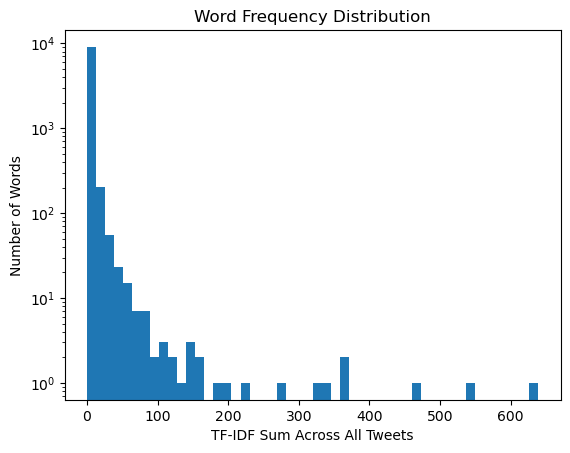

In [151]:

word_scores = np.array(X_tfidf.sum(axis=0)).flatten()
plt.hist(word_scores, bins=50)
plt.yscale("log")  # Log scale to see rare words more clearly
plt.xlabel("TF-IDF Sum Across All Tweets")
plt.ylabel("Number of Words")
plt.title("Word Frequency Distribution")
plt.show()


In [152]:

low_tfidf_words = np.array(
    tfidf.get_feature_names_out()
)[(X_tfidf.sum(axis=0) < 10).A1]

Now that we have our custom function ready, we can prepare a Pipeline for our baseline MultinomialNB model. 

This Pipeline will cover the following steps:
1. Run the Custom Transformer we just created.
2. Vectorize the text into TF-IDF features.
3. Run a MultinomialNB model.

In [157]:
# creating Pipeline for MultinomialNB modeling

baseline_pipe = Pipeline([
    ('preprocessor', TextPreprocessor()), # preprocessing transformer, 
                                                                      # removing custom + standard stop words
    ('vectorizer', TfidfVectorizer()), # Convert to TF-IDF features
    ('classifier', MultinomialNB(class_prior=[0.67, 0.33])), # Run the MultinomialNB model, adjusted for minority class
])

##### **Logistic Regression Model**

In [158]:
logreg_pipe = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(
        max_iter=1000, # increasing iterations to capture data complexity
        class_weight='balanced',# balancing in favor of minority class
        random_state=42 
    ))
])

# Modeling

With our two pipelines prepared, we can proceed with modeling.

First we will need to train the models on our training data and evaluate their performance using the metrics we outlined above (Precision and F1). 

In [159]:
# fitting and running baseline model (MultinomialNB)
baseline_pipe.fit(X_train['tweet_text'], y_train)

# predicting validation set
y_val_pred_baseline = baseline_pipe.predict(X_val['tweet_text'])

# evaluating baseline model
baseline_precision = precision_score(y_val, y_val_pred_baseline)
baseline_recall = recall_score(y_val, y_val_pred_baseline)
baseline_f1 = f1_score(y_val, y_val_pred_baseline)

print(f'Baseline Precision: {baseline_precision}')
print(f'Baseline Recall: {baseline_recall}')
print(f'Baseline F1: {baseline_f1}')


Baseline Precision: 0.8021978021978022
Baseline Recall: 0.15938864628820962
Baseline F1: 0.2659380692167577


While we have a decent Precision score of 80%, we have very poor Recall and F1 scores, indicating that while the model is good at identifying a positive class, it is allowing many actual positive cases to fall through the cracks.

Let's try our LogReg model and compare.

In [160]:
logreg_pipe.fit(X_train['tweet_text'], y_train)

y_val_pred_logreg = logreg_pipe.predict(X_val['tweet_text'])

logreg_precision = precision_score(y_val, y_val_pred_logreg)
logreg_recall = recall_score(y_val, y_val_pred_logreg)
logreg_f1 = f1_score(y_val, y_val_pred_logreg)

print(f'LogReg Precision: {logreg_precision}')
print(f'LogReg Recall: {logreg_recall}')
print(f'LogReg F1: {logreg_f1}')

LogReg Precision: 0.566990291262136
LogReg Recall: 0.6375545851528385
LogReg F1: 0.6002055498458376


While our LogReg model did significant worse in terms of Precision, it did much better in terms of Recall and F1 scores, inducating less positive cases are falling through the cracks here, however it is mispredicting a good number of Positive cases that are not actually Positive.

## Tuning Hyperparameters

# Conclusion

## Limitations

## Recommendations

## Next Steps